## View Saliency

Visualize the pixels in the input image that are important to the neural net arriving at a particular classification.

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import random
import numpy as np
from skimage import io
from scipy.ndimage.filters import gaussian_filter1d
from PIL import Image
import random, time, os, math
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We're going to need some helpful img processing functions.

In [2]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

In [3]:
def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

In [4]:
def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

In [5]:
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

Pass the pre-trained model and compute $\frac{d(score_{correct})}{d(img)}$. Set `param.requires_grad = False` to avoid calculating training gradients.

In [6]:
def dont_train_model(model):
    for param in model.parameters():
        param.requires_grad = False
    return model

In [23]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 5, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    model = dont_train_model(model)
    
    # Make input tensor require gradient
    X.requires_grad_()
    
    saliency = None

    # forward
    scores = model(X)
    correct_scores = scores.gather(1, y.view(-1, 1)).squeeze()
    
    # backward
    correct_scores.backward(torch.ones(correct_scores.size()))  # have to init with 1s
    saliency = X.grad  # gradient w.r.t. X
    
    # RBG, HoG, Hough --> 1D
    print(saliency.size())
    saliency, _ = torch.max(saliency.abs(), dim=1)  # pytorch ; dim : np ; axis

    return saliency

We have most of the pieces. Now we just need to plot the saliency maps.

In [8]:
def show_saliency_maps(X, y, model):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
#         plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

Let's test with Squeezenet, using a random class, before using on the more expensive models.

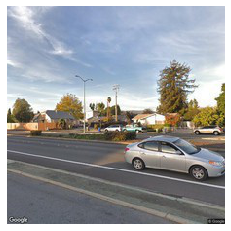

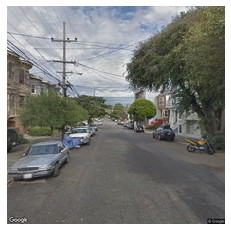

(2, 224, 224, 3)


In [9]:
# Download and load the pretrained SqueezeNet model.
model = torchvision.models.squeezenet1_1(pretrained=True)
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

file1 = 'images/sorted_data/noVeg/_37.53769954000002_-121.96785305999998_0_urban_0.jpg'
file2 = 'images/sorted_data/veg/_37.77441097_-122.45954106_1_urban_0.jpg'
img_np1 = io.imread(file1).astype(np.uint8)
img_np2 = io.imread(file2).astype(np.uint8)

figure = plt.figure()
plt.imshow(img_np1)
plt.axis('off')
plt.show()

plt.imshow(img_np2)
plt.axis('off')
plt.show()

img_np = np.stack((img_np1, img_np2), axis=0)
print(img_np.shape)

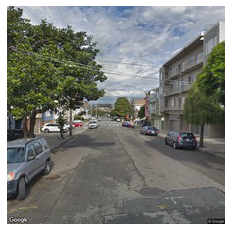

torch.Size([1, 5, 224, 224])


<Figure size 432x288 with 0 Axes>

In [234]:
model = torch.load('models/e278')

cat = 'veg_'
ID = 77

file_rgb = 'data/train/img/' + cat + str(ID) + '.pt'
file_hog = 'data/train/hog/'+ cat + str(ID) + '.pt'
file_hough = 'data/train/hough/'+ cat + str(ID) + '.pt'

img = torch.load(file_rgb)
img = torch.cat((img, torch.load(file_hog)), dim=0)
img = torch.cat((img, torch.load(file_hough)), dim=0)

img_np_5 = img.cpu().numpy().astype(np.uint8)
img_np_3 = img_np_5[:3, :, :].transpose((1, 2, 0))

figure = plt.figure()
plt.imshow(img_np_3)
plt.axis('off')
plt.show()
plt.savefig('img.jpg')
                    
model.cpu()
#img_cuda = torch.FloatTensor(img.view((1, 5, 224, 224))).cuda()
img = img.reshape(1,5,224,224).float()

y_tensor = torch.LongTensor(2*np.ones(1))
saliency = compute_saliency_maps(img, y_tensor, model)

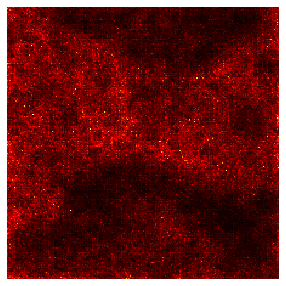

<Figure size 432x288 with 0 Axes>

In [233]:
#plt.subplot(2, 1, 1)
#img.requires_grad =False
#plt.imshow(img[0,:3].permute(1,2,0))
#plt.axis('off')
#         plt.title(class_names[y[i]]
#plt.subplot(2, 1, 2)
plt.imshow(saliency[0]**-0.7, cmap=plt.cm.hot)
plt.axis('off')
plt.gcf().set_size_inches(12, 5)
plt.show()
plt.savefig('saliency.jpg')

In [216]:
img[0,:3].shape

torch.Size([3, 224, 224])

In [115]:
np.max(saliency)

TypeError: max() missing 1 required positional arguments: "dim"

In [117]:
saliency.max()

tensor(0.0056)